# Real State Home Prices Micro Projections
## Final Project Draft
### Author By: Alexis M Montano

In [2]:
# Import libraries I be using
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pylab as pl
%matplotlib inline

## Experimental Write-Up
### Problem Statement
The 33 trillion house market affects 5.3 million Americans who have limited access to market data, and have to decide what is the proper price for a home as is the larger purchase and commitment of time we will make.

### Hypothesis
If home prices projection data is more readily available, then home purchases properly reflect homeowners ownership potential.

### Potential models to be used
- Logistic Regression

### Data dictionary and link to Zillow Research documentation

Variable | Data Type | Description | Type of Variable
---| ---| ---| ---
RegionID | Int | Numerical ID for each row entry | continuous
RegionName | Int |Region five-digit zip code as recorded by the zip code| categorical
City | String |Human settlement name in the United State as a record by the United State postal service | categorical 
State | String | Two letter code of the State as recorded in the United State postal service | categorical
CountyName | String | County name as recorded by the United State postal service | categorical
SizeRank| Int | Integer rank number as assign by market size | categorical
year_month | Date | Year and Month the Zillow Home Value Index (ZHVI) was recorder for the particular Region ID and Region Name. The ZHVI is a smoothed seasonally adjusted measure of the median estimated home value acros a given region and housing type. It is a dollar-denominated alternative to repeat-sales indices recorded by month | continuous
home_value | Int | Home value extimation per the ZHVI for the particular Region ID and Region Name per month | continuous

Detail information on Zillow datasets, methology and description could be found by visiting the following URL: https://www.zillow.com/research

### Outstanding questions, assumptions, risks, caveats

My outstanding question is the effect of other features not currently consider in the data set such as crime data, schools scores, average income, homes sold each month, homes inventory each month, and market influential items such as gain/loss of employers in the area. The assumption is that Zillow Home Value Index already consider some of this outstanding question or they don’t impact the model. The risk with my prior assumption is that a missing feature is not accounted for in the Zillow Home Value Index and it those indeed impact potential model performance. The caveat is that due to time constraints, gathering desire features such as crime data, school ratings, average income, and flags of employer’s impact is not visible.

### Goals and criteria to explain what success looks like

My goal is to forecast home values in a one, three, and six-month outlook with a 95% accuracy to assist in home buying decision making. Success will be to forecast values within the New York borough of Queens for at least one- and six-month intervals.

### Define your dataset

The dataset comes from Zillow Research data, accounting for home values calculated using the Zillow Home Value Index (ZHVI). The data include monthly home prices starting on April 1996 through May 2019. Some values for certain counties codes are missing for older years. However, my county of Queens on wish I am basing my model on is fully accounted for. The homes values are recorded as the whole integer per the ZHVI.

### My Sample size, number of features, and number of missing values

My sample size is 15,581 while the country of queens holds 52 zip codes on record. They are seven main features and 278 monthly home values variables from 1996 through 2019. From my target Queens county, they are no missing value. However, as I expand beyond Queens historical data those have missing metro values.

## Exploratory Data Analysis

In [3]:
# Import file to the data frame
fileLocation = "..\\data\\zip_zhvi_all_homes.csv"
df = pd.read_csv(fileLocation, low_memory=False)

### Data Cleaning Description

- Step 1 - Oraganize the data based on region prior to un-pivoting the yyyy-mm columns to rows for better analysis.
- Step 2 - Un-Pivot the data using the Melt function
- Step 3 - Applied proper labels and data types to year_month and home_value columns

In [4]:
# Step 1 - Organize all values based on Region ID
df = df.sort_values(by=['RegionID'])

In [5]:
# Step 2 - Un-Pivot the data using the Melt function
# Separate main columns from the frame
data = df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']]

# Drop columns not part of the un-pivot operations
df_to_melt = df.drop(['RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=False)

# Un-Pivot data base on the Region ID
df_melt = pd.melt(df_to_melt, id_vars='RegionID')

# Rename new columns variable and value to their proper names year_month, home_value
df_melt = df_melt.rename(index=str, columns={"variable":"year_month", "value":"home_value"})

# Join the data and df_melt back together to data
data = data.merge(df_melt, how='inner')

In [6]:
# Step 3 - Applied proper labels and data types to year_month and home_value columns

# Change the data type for year_month to a date type
data['year_month'] = pd.to_datetime(data['year_month'])

# Change the data type for home_value to a int64
data['home_value'] = data['home_value'].fillna(0).astype(np.int64)

### Exploratory Analysist

Review the data charasteristics such as its make-up, len, null values, drop columns not needed, and types.

In [7]:
# Select top five head records
data.head(5)

RegionID  RegionName    City State        Metro      CountyName  SizeRank  \
0     58196        1001  Agawam    MA  Springfield  Hampden County      6019   
1     58196        1001  Agawam    MA  Springfield  Hampden County      6019   
2     58196        1001  Agawam    MA  Springfield  Hampden County      6019   
3     58196        1001  Agawam    MA  Springfield  Hampden County      6019   
4     58196        1001  Agawam    MA  Springfield  Hampden County      6019   

  year_month  home_value  
0 1996-04-01      103900  
1 1996-05-01      104200  
2 1996-06-01      104500  
3 1996-07-01      104800  
4 1996-08-01      105000

In [8]:
# Length of the dataframe
len(data)

4331240

In [9]:
# Count number of items null
data.isnull().sum()

RegionID           0
RegionName         0
City               0
State              0
Metro         377246
CountyName         0
SizeRank           0
year_month         0
home_value         0
dtype: int64

In [10]:
# Drop the metro columns in place due to large number of null values
data.drop(["Metro"], axis=1, inplace=True)
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'CountyName', 'SizeRank',
       'year_month', 'home_value'],
      dtype='object')

In [11]:
# Get DataFrame Columns data types
data.dtypes

RegionID               int64
RegionName             int64
City                  object
State                 object
CountyName            object
SizeRank               int64
year_month    datetime64[ns]
home_value             int64
dtype: object

In [12]:
# Filter down data to Queens County
data2 = data[(data["CountyName"]=="Queens County")]
data2.head(10)

RegionID  RegionName      City State     CountyName  SizeRank  \
451472     61979       11004  New York    NY  Queens County      7900   
451473     61979       11004  New York    NY  Queens County      7900   
451474     61979       11004  New York    NY  Queens County      7900   
451475     61979       11004  New York    NY  Queens County      7900   
451476     61979       11004  New York    NY  Queens County      7900   
451477     61979       11004  New York    NY  Queens County      7900   
451478     61979       11004  New York    NY  Queens County      7900   
451479     61979       11004  New York    NY  Queens County      7900   
451480     61979       11004  New York    NY  Queens County      7900   
451481     61979       11004  New York    NY  Queens County      7900   

       year_month  home_value  
451472 1996-04-01      214800  
451473 1996-05-01      214900  
451474 1996-06-01      215100  
451475 1996-07-01      215300  
451476 1996-08-01      215500  
451477 1996-09-01      215700  
451478 1996-10-01      215900  
451479 1996-11-01      216300  
451480 1996-12-01      216900  
451481 1997-01-01      217400

### Explore Statistical features of the dataset

Understand the shape, and statistical features of the Queens country subset, such as mean, median, mininal, maximus and standard deviation of the data.

In [13]:
# The shape of the DataFrame filter only by Queens County
data2.shape

(14456, 8)

In [14]:
# The Mean home value for Queens County in the data set?
data2['home_value'].mean()

419607.8029883785

In [15]:
# The median home value for Queens County in the data set?
data2['home_value'].median()

404100.0

In [16]:
# The minimum home value for Queens County in the data set?
data2['home_value'].min()

95400

In [17]:
# The maximum home value for Queens County in the data set?
data2['home_value'].max()

1098700

In [18]:
# The Standard Deviation of home values for Queens County in the data set?
data2['home_value'].std()

186785.18364358207

### Visuals: Visualization of the dataset

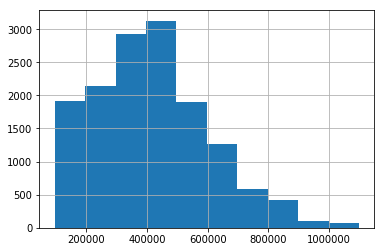

In [19]:
# Histogram of Queens County home values in the data set?
data2['home_value'].hist()

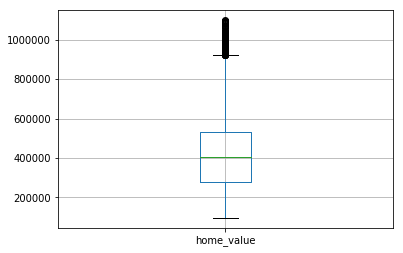

In [20]:
# Boxplot of Queens County home values in the data set?
data2.boxplot(column=['home_value'])

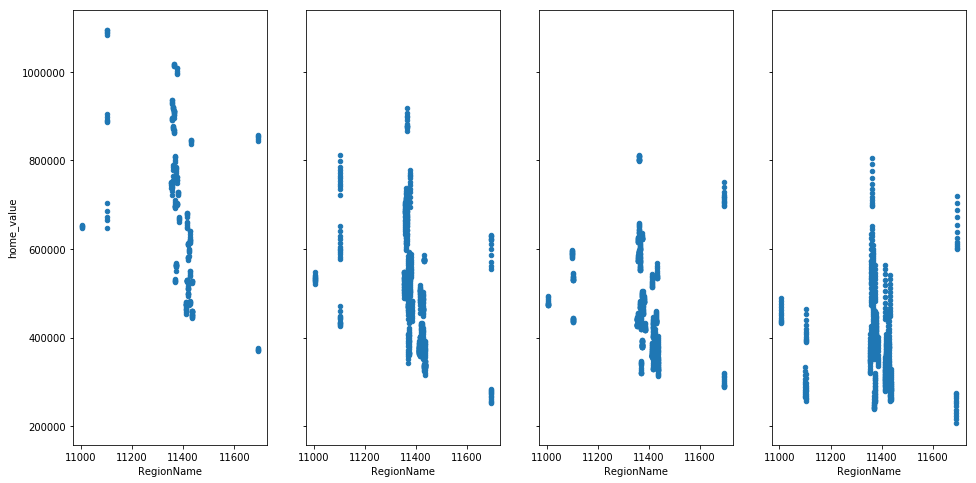

In [21]:
# visualize the relationship between the cities in Queens County and home values in the current year, five, ten and fifteen years
fig, axs = plt.subplots(1, 4, sharey=True)
data_current_year = data2[data2['year_month'].dt.year == pd.datetime.now().year]
data_last_five_years = data2[data2['year_month'].dt.year == pd.datetime.now().year-5]
data_last_ten_years = data2[data2['year_month'].dt.year == pd.datetime.now().year-10]
data_last_fifteen_years = data2[data2['year_month'].dt.year == pd.datetime.now().year-15]
data_current_year.plot(kind='scatter', x='RegionName', y='home_value', ax=axs[0], figsize=(16, 8))
data_last_five_years.plot(kind='scatter', x='RegionName', y='home_value', ax=axs[1], figsize=(16,8))
data_last_ten_years.plot(kind='scatter', x='RegionName', y='home_value', ax=axs[2], figsize=(16, 8))
data_last_fifteen_years.plot(kind='scatter', x='RegionName', y='home_value', ax=axs[3], figsize=(16, 8))

In [22]:
# The top 10 lowest price homes historically?
data2[['RegionName','year_month','home_value']].sort_values(by=['home_value'], ascending=True).head(10)

RegionName year_month  home_value
468986       11372 1996-04-01       95400
468987       11372 1996-05-01       96400
468988       11372 1996-06-01       97400
468989       11372 1996-07-01       98400
468990       11372 1996-08-01       99400
468991       11372 1996-09-01      100400
468992       11372 1996-10-01      101300
468993       11372 1996-11-01      102300
468994       11372 1996-12-01      103400
468995       11372 1997-01-01      104400

In [23]:
# The top 10 highest price homes historically?
data2[['RegionName','year_month','home_value']].sort_values(by=['home_value'], ascending=False).head(10)

RegionName year_month  home_value
454523       11101 2018-11-01     1098700
454522       11101 2018-10-01     1097500
454528       11101 2019-04-01     1095300
454524       11101 2018-12-01     1094100
454521       11101 2018-09-01     1094100
454529       11101 2019-05-01     1093800
454520       11101 2018-08-01     1090100
454527       11101 2019-03-01     1089800
454525       11101 2019-01-01     1087700
454519       11101 2018-07-01     1087600

### Model Building

In this section we will prepared the data to be fit and perform a logistic regression on the Zillow home data sub-set of Queens County.

#### Fit the model

In [25]:
lm = smf.ols(formula='home_value ~ RegionName + SizeRank + year_month', data=data2).fit()

#### Print the summary results

In [26]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     83.09
Date:                Sat, 13 Jul 2019   Prob (F-statistic):               0.00
Time:                        11:39:12   Log-Likelihood:            -1.8897e+05
No. Observations:               14456   AIC:                         3.785e+05
Df Residuals:                   14176   BIC:                         3.806e+05
Df Model:                         279                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                       2.337e+06   1.04e+05     22.536      0.000    2.13e+06    2.54e+06
year_month[T.Timestamp('1996-05-01 00:00:00')]   326.9231   2.28e+04      0.014      0.989   -4.43e+04     4.5e+04
year_month[T.Timestamp('1996-06-01 00:00:00')]   763.4615   2.28e+04      0.034      0.973   -4.39e+04    4.54e+04
year_month[T.Timestamp('1996-07-01 00:00:00')]  1240.3846   2.28e+04      0.054      0.957   -4.34e+04    4.59e+04
year_month[T.Timestamp('1996-08-01 00:00:00')]  1711.5385   2.28e+04      0.075      0.940    -4.3e+04    4.64e+04
year_month[T.Timestamp('1996-09-01 00:00:00')]  2140.3846   2.28e+04      0.094      0.925   -4.25e+04    4.68e+04
year_month[T.Timestamp('1996-10-01 00:00:00')]  2540.3846   2.28e+04      0.111      0.911   -4.21e+04    4.72e+04
year_month[T.Timestamp('1996-11-01 00:00:00')]  3092.3077   2.28e+04      0.136      0.892   -4.16e+04    4.78e+04
year_month[T.Timestamp('1996-12-01 00:00:00')]  3801.9231   2.28e+04      0.167      0.867   -4.09e+04    4.85e+04
year_month[T.Timestamp('1997-01-01 00:00:00')]  4338.4615   2.28e+04      0.190      0.849   -4.03e+04     4.9e+04
year_month[T.Timestamp('1997-02-01 00:00:00')]  4490.3846   2.28e+04      0.197      0.844   -4.02e+04    4.92e+04
year_month[T.Timestamp('1997-03-01 00:00:00')]  4494.2308   2.28e+04      0.197      0.844   -4.02e+04    4.92e+04
year_month[T.Timestamp('1997-04-01 00:00:00')]  4659.6154   2.28e+04      0.204      0.838      -4e+04    4.93e+04
year_month[T.Timestamp('1997-05-01 00:00:00')]  5084.6154   2.28e+04      0.223      0.823   -3.96e+04    4.97e+04
year_month[T.Timestamp('1997-06-01 00:00:00')]  5736.5385   2.28e+04      0.252      0.801   -3.89e+04    5.04e+04
year_month[T.Timestamp('1997-07-01 00:00:00')]  6482.6923   2.28e+04      0.284      0.776   -3.82e+04    5.11e+04
year_month[T.Timestamp('1997-08-01 00:00:00')]  7305.7692   2.28e+04      0.321      0.749   -3.74e+04     5.2e+04
year_month[T.Timestamp('1997-09-01 00:00:00')]  8163.4615   2.28e+04      0.358      0.720   -3.65e+04    5.28e+04
year_month[T.Timestamp('1997-10-01 00:00:00')]  9055.7692   2.28e+04      0.397      0.691   -3.56e+04    5.37e+04
year_month[T.Timestamp('1997-11-01 00:00:00')]  1.017e+04   2.28e+04      0.446      0.655   -3.45e+04    5.48e+04
year_month[T.Timestamp('1997-12-01 00:00:00')]   1.15e+04   2.28e+04      0.505      0.614   -3.32e+04    5.62e+04
year_month[T.Timestamp('1998-01-01 00:00:00')]  1.264e+04   2.28e+04      0.555      0.579    -3.2e+04    5.73e+04
year_month[T.Timestamp('1998-02-01 00:00:00')]  1.335e+04   2.28e+04      0.586      0.558   -3.13e+04     5.8e+04
year_month[T.Timestamp('1998-03-01 00:00:00')]  1.394e+04   2.28e+04      0.612      0.541   

### Methods: Write up the methods used in your analysis

Answer:

### Results: Write up your results

Answer:

### Visuals: Provide a table or visualization of these results

Answer:

### Discussion: Write up your discussion and future steps

Answer: